## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
import pandas as pd
import numpy as np
import os, sys
from PIL import Image

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
faces = pd.read_csv('/datasets/faces/labels.csv')
faces.shape

(7591, 2)

In [ ]:
faces.head()

In [3]:
faces.duplicated().sum()

0

In [4]:
faces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
faces.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**Conclusion**

The dataset contains a total of 7591 faces, with no instances of missing values or duplicates. The average age of individuals in the dataset is 31, with age values ranging from 1 year to 100 years.

## EDA

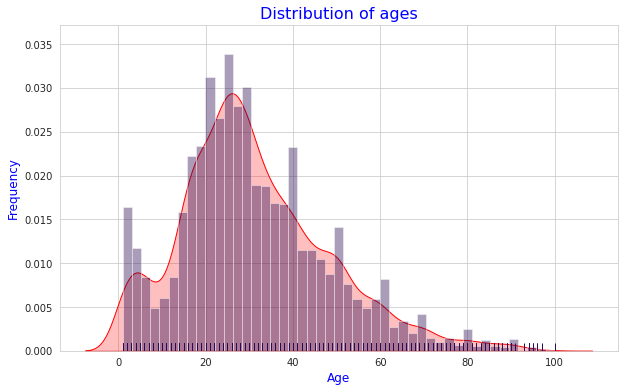

In [6]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(faces['real_age'], rug=True, kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Age', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Distribution of ages', fontsize=16, color='b')
plt.show()

From the plot provided above, it is evident that the images depict individuals from different age groups. Nevertheless, the largest portion of the images consists of people aged between 20 and 40 years. Additionally, there are a relatively small number of adorable baby photos, specifically less than 10.

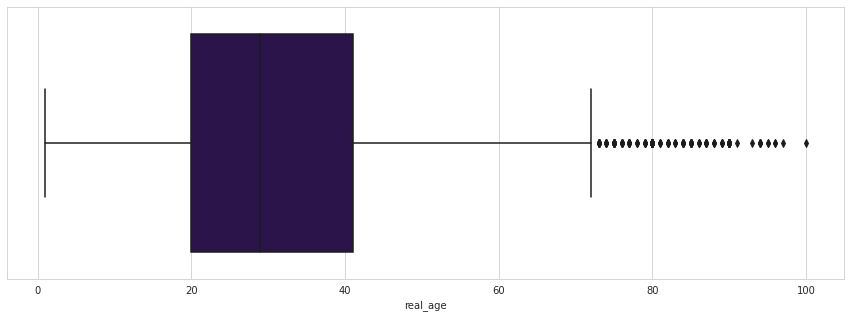

In [7]:
plt.figure(figsize=(15,5))
sns.boxplot(faces["real_age"])
plt.show()

skewed normal distribution

In [8]:
# create datagenerator object for training and validation datasets
#rescale images using 1/255
train_datagen = ImageDataGenerator(
            #we will do normalization for image pixel values as following
            rescale=1 / 255
            )

#use flow_from_dataframe method to load images from directory and labels from dataframe
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = faces,
    directory='/datasets/faces/final_files/',
    x_col="file_name", 
    y_col="real_age",
    #we are doing regression, so we will assign class_mode to 'raw'
    class_mode="raw",
    #to convert all images to same pixel size, for neural networks, all images should have similar size
    target_size=(224,224),
    #we will load images batch by batch (every time 32 images will be loaded)
    batch_size=32,
    seed=12345,
    )

Found 7591 validated image filenames.


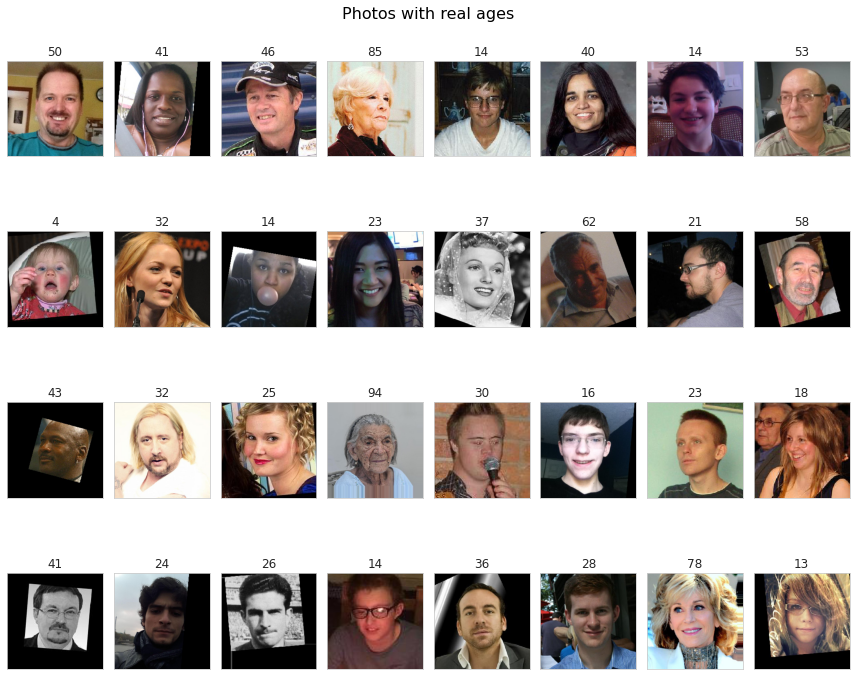

In [9]:
#get one batch from our datagenerator and display images in it
features, target = next(train_datagen_flow)

# display 16 images
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
	# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Photos with real ages',  y=0.9,fontsize=16, color='k')
    plt.tight_layout()

### Findings

In [10]:
print(features.shape, target.shape)

(32, 224, 224, 3) (32,)


- Found 7591 validated image filenames.

- The pictures have been edited to remove unnecessary parts and a few of them have been turned around.

- Additional flaws can be observed in the background, such as inadequate lighting.

- It remains uncertain if this collection of data represents diverse races and so on.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you checked target distribution and looked at a few examples of images
    

</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [11]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [15]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345)

    return train_gen_flow

In [16]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_gen_flow = validation_datagen.flow_from_dataframe(
    dataframe = labels,
    directory=path +'/final_files/',
    x_col="file_name",
    y_col="real_age", 
    class_mode="raw", 
    target_size=(224,224), 
    batch_size=32,
    subset = "validation",
    seed=12345,
    )

    return test_gen_flow

<div class="alert alert-success">
<b>Reviewer's comment</b>

The code for data loading is correct

</div>

In [17]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    # we will use ResNet50 architecture, with freezing top layers
    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet', 
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae']) 
    return model
    print(model.summary())

    return model

In [18]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

<div class="alert alert-success">
<b>Reviewer's comment</b>

The model is created and trained correctly

</div>

In [20]:
#assign data directory
path = '/datasets/faces/'
#load training and testing (actually this is validation data set)
train_data = load_train(path)
test_data = load_test(path)

#build a model
model = create_model(input_shape = (224, 224, 3))

Found 5694 validated image filenames.
Found 1897 validated image filenames.


## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

**Solution**

because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-21 17:35:42.171561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14988 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 53s - loss: 186.4147 - mae: 10.2717 - val_loss: 315.8279 - val_mae: 13.1225/
Epoch 2/10
178/178 - 37s - loss: 96.8904 - mae: 7.4692 - val_loss: 517.0974 - val_mae: 17.5486/
Epoch 3/10
178/178 - 37s - loss: 66.8883 - mae: 6.2594 - val_loss: 293.3286 - val_mae: 12.7421/
Epoch 4/10
178/178 - 37s - loss: 45.5540 - mae: 5.1559 - val_loss: 159.4267 - val_mae: 9.8266/
Epoch 5/10
178/178 - 37s - loss: 31.5216 - mae: 4.3359 - val_loss: 145.7763 - val_mae: 9.0718/
Epoch 6/10
178/178 - 37s - loss: 24.4756 - mae: 3.8257 - val_loss: 104.8930 - val_mae: 7.9730/
Epoch 7/10
178/178 - 37s - loss: 17.4663 - mae: 3.2486 - val_loss: 79.1837 - val_mae: 6.9253/
Epoch 8/10
178/178 - 37s - loss: 12.7989 - mae: 2.7478 - val_loss: 82.0916 - val_mae: 6.8985/
Epoch 9/10
178/178 - 37s - loss: 12.4593 - mae: 2.6798 - val_loss: 83.0260 - val_mae: 7.1038/
Epoch 10/10
178/178 - 37s - loss: 10.2615 - mae: 2.4200 - val_loss: 90.3262 - val_mae: 7.1176/

60/60 - 9s - loss: 90.3262 - mae: 7.1176
Test MAE: 7.1176

<div class="alert alert-success">
<b>Reviewer's comment</b>

The model was trained successfully!

</div>

## Conclusions

The model has achieved the desired value metric; however, in order to obtain a mean absolute error (MAE) equal 7.11, we can also employ the technique of early stopping, which allows us to obtain the desired result sooner. Additionally, it is considered good practice to plot the learning curve and perform a thorough check.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Well done!

</div>

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training